In [1]:
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers import Input
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
path = '/mt/batch/jaraz/RNN_CNN/ANALYSIS_1/images2/'
qcd     = np.load(path+'train/QCD_train_001_10000_norm.npz')
tt      = np.load(path+'train/tt_train_001_10000_norm.npz')
df_full = np.vstack((tt['image'],qcd['image']))
df_full = df_full.reshape(20000,37,37,1)

qcd_val = np.load(path+'val/QCD_val_001_10000_norm.npz')
tt_val  = np.load(path+'val/tt_val_001_10000_norm.npz')
df_val  = np.vstack((tt_val['image'],qcd_val['image']))
df_val  = df_val.reshape(20000,37,37,1)

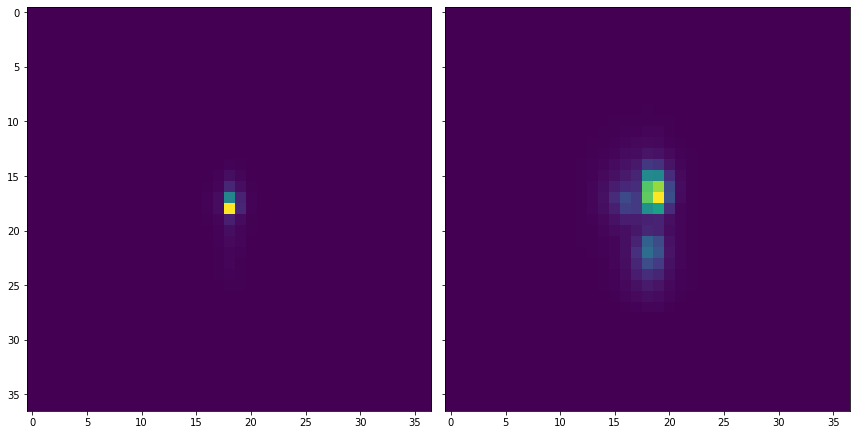

In [3]:
fig, axarr = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12, 6)
axarr[0].imshow(np.array(qcd['image']).mean(axis=0))
axarr[1].imshow(np.array(tt['image']).mean(axis=0))
plt.tight_layout()
plt.show()

In [5]:
inputList   = Input(shape=(37,37,1))
hidden = Conv2D(8, (4, 4), activation='relu',padding='same')(inputList)
hidden = Conv2D(8, (4, 4), activation='relu',padding='same')(hidden)
hidden = MaxPooling2D(pool_size=(2, 2))(hidden)
hidden = Conv2D(8, (4, 4), activation='relu',padding='same')(hidden)
hidden = Conv2D(8, (4, 4), activation='relu',padding='same')(hidden)
hidden = Flatten()(hidden)
hidden = Dense(64, activation='relu')(hidden)
hidden = Dense(64, activation='relu')(hidden)
hidden = Dense(64, activation='relu')(hidden)
output = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=inputList, outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 37, 37, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 8)         136       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 8)         1032      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 8)         1032      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 8)         1032      
_________________________________________________________________
flatten_1 (Flatten)          (None, 2592)              0   

In [7]:
y = []
y.extend([1]*10000)
y.extend([0]*10000)
y_val = []
y_val.extend([1]*10000)
y_val.extend([0]*10000)

In [8]:
batch_size = 128
n_epochs = 50

history = model.fit(df_full, np.array(y), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    verbose = 1,
                    validation_data=(df_val, np.array(y_val)),
                    callbacks = [
                    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                    TerminateOnNaN()])

Train on 20000 samples, validate on 20000 samples
Epoch 1/50
20000/20000 [==============================] - 5s 274us/step - loss: 0.4152 - accuracy: 0.8257 - val_loss: 0.3002 - val_accuracy: 0.8801
Epoch 2/50
20000/20000 [==============================] - 4s 218us/step - loss: 0.2737 - accuracy: 0.8856 - val_loss: 0.2411 - val_accuracy: 0.9029
Epoch 3/50
20000/20000 [==============================] - 4s 216us/step - loss: 0.2433 - accuracy: 0.9012 - val_loss: 0.2530 - val_accuracy: 0.8986
Epoch 4/50
20000/20000 [==============================] - 4s 214us/step - loss: 0.2369 - accuracy: 0.9028 - val_loss: 0.2224 - val_accuracy: 0.9117
Epoch 5/50
20000/20000 [==============================] - 4s 215us/step - loss: 0.2285 - accuracy: 0.9072 - val_loss: 0.2247 - val_accuracy: 0.9108
Epoch 6/50
20000/20000 [==============================] - 4s 219us/step - loss: 0.2272 - accuracy: 0.9079 - val_loss: 0.2227 - val_accuracy: 0.9122

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00

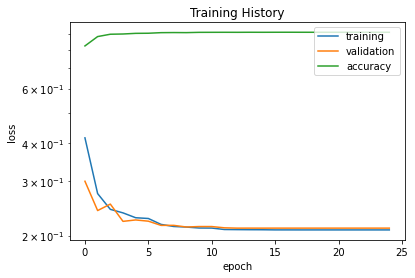

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation','accuracy'], loc='upper right')

In [13]:
qcd_test = np.load(path+'test/QCD_test_001_10000_norm.npz')
tt_test = np.load(path+'test/tt_test_001_10000_norm.npz')
df_test = np.vstack((tt_test['image'],qcd_test['image']))
y_test = []
y_test.extend([1]*len(tt_test['image']))
y_test.extend([0]*len(qcd_test['image']))
df_test = df_test.reshape(20000,37,37,1)

In [14]:
yhat = model.predict(df_test, verbose = True)

20000/20000 [==============================] - 3s 161us/step


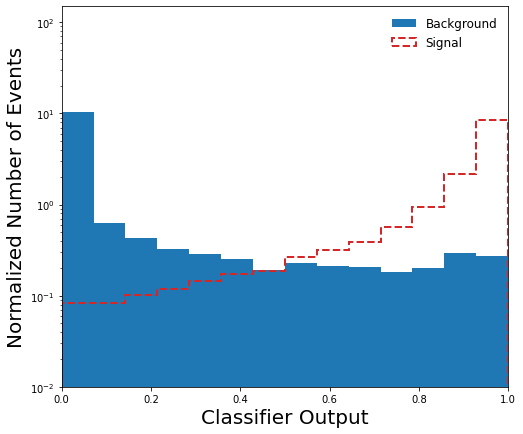

In [15]:
fig = plt.figure(figsize=(8, 7), facecolor='w', edgecolor='k')
# sys1 = fig.add_subplot()
binss = np.linspace(0,1,15)
bkg = plt.hist(yhat[np.array(y_test) != 1],
         histtype='bar',  bins=binss, 
         label=r'Background',density=True,
         linewidth=0, color='tab:blue', linestyle='solid')
sig = plt.hist(yhat[np.array(y_test) == 1],
         histtype='step', bins=binss, 
         label=r'Signal',
         color=None, edgecolor='tab:red', linewidth=2, linestyle="dashed",
         bottom=None, cumulative=False, density=True, align="mid", orientation="vertical")
leg = plt.legend(loc='upper right',fontsize=12)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
# plt.xaxis.set_major_locator(MultipleLocator(0.2))
# plt.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.xaxis.set_minor_locator(MultipleLocator(0.2/5.))
plt.xlabel('Classifier Output',fontsize=20)
plt.ylabel('Normalized Number of Events',fontsize=20)
plt.axis([0,1,1e-2,150])
plt.yscale("log", nonposy='clip')
plt.show()

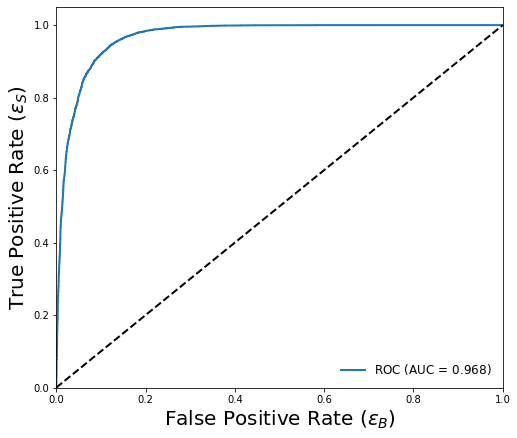

In [16]:
from sklearn.metrics import roc_curve, auc
## Plot ROC
# Signal labal is 0 
fpr, tpr, tresholds = roc_curve(y_test, yhat,pos_label=1, 
                                drop_intermediate=False)
# fpr, tpr, tresholds = roc_curve(y_test, yhat[:,0])
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(8, 7), facecolor='w', edgecolor='k')
# sys2 = fig.add_subplot()

# sys2.plot(tpr, 1./fpr,color='tab:blue',lw=2,
#           label=r'ROC (AUC = ${:.3f}$)'.format(roc_auc))
plt.plot(fpr, tpr,color='tab:blue',lw=2,
          label=r'ROC (AUC = ${:.3f}$)'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.axis([0,1,0,1.05])
# sys2.set_xlim((0, 1))
# sys2.set_ylim((1, 1000))
# sys2.set_yscale('log')
plt.xlabel('False Positive Rate ($\epsilon_B$)',fontsize=20)
plt.ylabel('True Positive Rate ($\epsilon_S$)',fontsize=20)
# plt.xaxis.set_major_locator(MultipleLocator(.2))
# plt.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.xaxis.set_minor_locator(MultipleLocator(.2/5.))
# plt.yaxis.set_major_locator(MultipleLocator(.2))
# plt.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.yaxis.set_minor_locator(MultipleLocator(.2/5.))
leg = plt.legend(loc='best',fontsize=12)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
#plt.savefig(os.path.join(path,'roc_curve.png'),bbox_inches='tight')
plt.show()

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test, [(x>0.8) for x in yhat.reshape(20000)], 
                           labels=[1,0],
                           target_names=['tt','jj']))

              precision    recall  f1-score   support

          tt       0.94      0.82      0.87     10000
          jj       0.84      0.95      0.89     10000

    accuracy                           0.88     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.88      0.88     20000

